In [ ]:
pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.3 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 30.8 MB/s 
     |████████████████████████████████| 34.5 MB 12 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from art.attacks.evasion import FeatureAdversariesPyTorch
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist
import random
from random import sample
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from art.attacks.inference.membership_inference import MembershipInferenceBlackBoxRuleBased
from art.attacks.inference.model_inversion.mi_face import MIFace

In [ ]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()
x_train = MinMaxScaler().fit_transform(x_train.reshape(60000,784))
x_test = MinMaxScaler().fit_transform(x_test.reshape(10000,784))
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=1/6.0, random_state=42)
x_train=torch.tensor(x_train).float().reshape(50000,1,784)
x_test=torch.tensor(x_test).float().reshape(10000,1,784)
x_valid=torch.tensor(x_valid).float().reshape(10000,1,784)

In [ ]:
# Dataloader class

from torch.utils.data import Dataset

class Mnist(Dataset):
    def __init__(self,x,y):
        self.data=x
        self.label=y
  
    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        x=self.data[idx]
        y=self.label[idx]
        return x,y

In [ ]:
train_data=Mnist(x_train,y_train)
test_data=Mnist(x_test,y_test)
valid_data=Mnist(x_valid,y_valid)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=100, shuffle=True)
valid_loader=torch.utils.data.DataLoader(dataset=valid_data,batch_size=100,shuffle=True)

## Data generator

In [ ]:
def generate_data(x,y,samples,new_data,var,ran_state):
  """
  x: Features of data to be sampled from
  y: Labels of data to be sampled from
  samples: number of samples from each class to be drawn
  new_data: Number of datapoints of each class to be generated
  var: Amount of variance to be added
  ran_state: Random state/seed
  """

  zero_sample=sample(list(np.array(np.where(np.argmax(y,axis=1)==0)).flatten()),samples)
  one_sample=sample(list(np.array(np.where(np.argmax(y,axis=1)==1)).flatten()),samples)
  two_sample=sample(list(np.array(np.where(np.argmax(y,axis=1)==2)).flatten()),samples)
  three_sample=sample(list(np.array(np.where(np.argmax(y,axis=1)==3)).flatten()),samples)
  four_sample=sample(list(np.array(np.where(np.argmax(y,axis=1)==4)).flatten()),samples)
  five_sample=sample(list(np.array(np.where(np.argmax(y,axis=1)==5)).flatten()),samples)
  six_sample=sample(list(np.array(np.where(np.argmax(y,axis=1)==6)).flatten()),samples)
  seven_sample=sample(list(np.array(np.where(np.argmax(y,axis=1)==7)).flatten()),samples)
  eight_sample=sample(list(np.array(np.where(np.argmax(y,axis=1)==8)).flatten()),samples)
  nine_sample=sample(list(np.array(np.where(np.argmax(y,axis=1)==9)).flatten()),samples)

  zero_sample_mean=np.mean(np.array(x[zero_sample]),axis=0)
  one_sample_mean=np.mean(np.array(x[one_sample]),axis=0)
  two_sample_mean=np.mean(np.array(x[two_sample]),axis=0)
  three_sample_mean=np.mean(np.array(x[three_sample]),axis=0)
  four_sample_mean=np.mean(np.array(x[four_sample]),axis=0)
  five_sample_mean=np.mean(np.array(x[five_sample]),axis=0)
  six_sample_mean=np.mean(np.array(x[six_sample]),axis=0)
  seven_sample_mean=np.mean(np.array(x[seven_sample]),axis=0)
  eight_sample_mean=np.mean(np.array(x[eight_sample]),axis=0)
  nine_sample_mean=np.mean(np.array(x[nine_sample]),axis=0)

  zero_var=np.var(np.array(x[zero_sample]),axis=0)
  one_var=np.var(np.array(x[one_sample]),axis=0)
  two_var=np.var(np.array(x[two_sample]),axis=0)
  three_var=np.var(np.array(x[three_sample]),axis=0)
  four_var=np.var(np.array(x[four_sample]),axis=0)
  five_var=np.var(np.array(x[five_sample]),axis=0)
  six_var=np.var(np.array(x[six_sample]),axis=0)
  seven_var=np.var(np.array(x[seven_sample]),axis=0)
  eight_var=np.var(np.array(x[eight_sample]),axis=0)
  nine_var=np.var(np.array(x[nine_sample]),axis=0)

  gen_zero=np.random.normal(zero_sample_mean,var*zero_var,size=(new_data,784))
  gen_one=np.random.normal(one_sample_mean,var*one_var,size=(new_data,784))
  gen_two=np.random.normal(two_sample_mean,var*two_var,size=(new_data,784))
  gen_three=np.random.normal(three_sample_mean,var*three_var,size=(new_data,784))
  gen_four=np.random.normal(four_sample_mean,var*four_var,size=(new_data,784))
  gen_five=np.random.normal(five_sample_mean,var*five_var,size=(new_data,784))
  gen_six=np.random.normal(six_sample_mean,var*six_var,size=(new_data,784))
  gen_seven=np.random.normal(seven_sample_mean,var*seven_var,size=(new_data,784))
  gen_eight=np.random.normal(eight_sample_mean,var*eight_var,size=(new_data,784))
  gen_nine=np.random.normal(nine_sample_mean,var*nine_var,size=(new_data,784))

  gen=np.vstack((gen_zero,gen_one,gen_two,gen_three,gen_four,gen_five,gen_six,gen_seven,gen_eight,gen_nine))
  labels_gen=np.hstack((new_data*[0],new_data*[1],new_data*[2],new_data*[3],new_data*[4],new_data*[5],new_data*[6],new_data*[7],new_data*[8],new_data*[9]))

  gen=shuffle(gen,random_state=ran_state)
  labels_gen=shuffle(labels_gen,random_state=ran_state)

  return gen, labels_gen

In [ ]:
train_gen,labels_gen=generate_data(x_train,y_train,1000,5000,0.2,0)
gen_data=Mnist(train_gen,labels_gen)
gen_loader = torch.utils.data.DataLoader(dataset=gen_data, batch_size=100, shuffle=True)

In [ ]:
def train(train_loader,valid_loader,model,output,epochs =400):
  """
  train_loader: train_loader object created with pytorch dataloader
  valid_loader: valid_loader object created with pytocrh dataloader
  model: Pytorch model to be trained
  output: string input - output file name
  epochs : Epochs to train
  """
  device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  trainloss=[]
  validloss=[]
  model.to(device)
  min_valid_loss = np.inf
  for epoch in range(int(epochs)):
    model.train()
    train_loss=0.0
    for i, (images, labels) in enumerate(train_loader):
      images=Variable(images).float().to(device)
      labels=Variable(labels).to(device)
      optimizer.zero_grad()
      outputs=model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss+=loss.item()

    valid_loss=0.0
    model.eval()
    for i,(images,labels) in enumerate(valid_loader):
      images=Variable(images).float().to(device)
      labels=Variable(labels).to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      valid_loss+=loss.item()
    trainloss.append(train_loss/ len(train_loader))
    validloss.append(valid_loss/ len(valid_loader))

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(valid_loader)}')
    if min_valid_loss > valid_loss/len(valid_loader):
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss/ len(valid_loader):.6f}) \t Saving The Model')
        min_valid_loss = valid_loss/ len(valid_loader)
        # Saving State Dict
        torch.save(model.state_dict(), '/content/drive/MyDrive/trained_models/'+output)
  return trainloss,validloss

In [ ]:
def test(models,test_loader):
  """
  If one model is given, it's simple test loop. If two models are given, then it's a comparison between the victim and the attacker models (first model is the victim, second is the attacker)
  """
  if len(models)==1:
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    models[0].to(device)
    testloss=0.0
    test_loss=[]
    acc=[]
    models[0].eval()
    for i,(images,labels) in enumerate(test_loader):
      images=Variable(images).float().to(device)
      labels=Variable(labels).to(device)
      outputs = models[0](images)
      loss = criterion(outputs, labels)
      testloss+=loss.item()
      accuracy=100*sum(torch.argmax(outputs,dim=1)==torch.argmax(labels,dim=1))/len(test_loader)
      acc.append(accuracy.item())
    test_loss.append(testloss/len(test_loader))
  elif len(models)==2:
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    models[0].to(device)
    models[1].to(device)
    testloss=0.0
    test_loss=[]
    acc=[]
    models[0].eval()
    for i,(images,labels) in enumerate(test_loader):
      images=Variable(images).float().to(device)
      labels=Variable(labels).to(device)
      victim = models[0](images)
      attack=models[1](images)
      loss = criterion(victim, attack)
      testloss+=loss.item()
      accuracy=100*sum(torch.max(victim,dim=1).indices==torch.max(attack,dim=1).indices)/len(test_loader)
      acc.append(accuracy.item())
    test_loss.append(testloss/len(test_loader))
  return {"avg_test_loss":np.mean(test_loss),"avg_test_acc":np.mean(acc)}

In [ ]:
def attack_loop(victim, attack, train_loader,test_loader,epochs,output):
  """
  victim : Model to be attacked
  attack: Model to attack with
  train_loader : train_loader object made with pytorch dataloader
  test_loader : test_loader object made with pytorch dataloader
  epochs : Epochs to train
  output: string input - output file name
  """
  device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  trainloss=[]
  validloss=[]
  victim.to(device)
  attack.to(device)
  min_valid_loss = np.inf
  acc=[]
  for epoch in range(int(epochs)):
    
    train_loss=0.0
    for i, (images, labels) in enumerate(train_loader):
      attack.train()
      victim.eval()
      images=Variable(images).squeeze().float().to(device)
      labels=Variable(labels).to(device)
      optimizer.zero_grad()
      attacked = attack(images)
      victimised = victim(images)
      loss = criterion(attacked, victimised)
      loss.backward()
      optimizer.step()
      train_loss+=loss.item()
    scheduler.step()
    valid_loss=0.0
    accuracy=0
    
    for i,(images,labels) in enumerate(test_loader):
      attack.eval()
      victim.eval()
      images=Variable(images).squeeze().float().to(device)
      labels=Variable(labels).to(device)
      attacked = attack(images)
      loss = criterion(attacked,labels)
      valid_loss+=loss.item()
      accuracy+=100*sum(torch.argmax(labels,dim=1)==torch.argmax(attacked,dim=1))/len(test_loader)
    trainloss.append(train_loss/ len(train_loader))
    validloss.append(valid_loss/ len(valid_loader))
    acc.append(accuracy.item()/len(test_loader))
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(valid_loader)}')
    print("Validation accuracy",acc[-1])
    if min_valid_loss > valid_loss/len(valid_loader):
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss/ len(valid_loader):.6f}) \t Saving The Model')
        min_valid_loss = valid_loss/ len(valid_loader)
        # Saving State Dict
        torch.save(attack.state_dict(), '/content/drive/MyDrive/trained_models/'+output)
  return trainloss,validloss,acc

In [ ]:
def calc_precision_recall(predicted, actual, positive_value=1):
    score = 0  # both predicted and actual are positive
    num_positive_predicted = 0  # predicted positive
    num_positive_actual = 0  # actual positive
    for i in range(len(predicted)):
        if predicted[i] == positive_value:
            num_positive_predicted += 1
        if actual[i] == positive_value:
            num_positive_actual += 1
        if predicted[i] == actual[i]:
            if predicted[i] == positive_value:
                score += 1
    
    if num_positive_predicted == 0:
        precision = 1
    else:
        precision = score / num_positive_predicted  # the fraction of predicted “Yes” responses that are correct
    if num_positive_actual == 0:
        recall = 1
    else:
        recall = score / num_positive_actual  # the fraction of “Yes” responses that are predicted correctly

    return precision, recall


# CNN model

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional Neural Network Layer 
        self.convolutaional_neural_network_layers = nn.Sequential(
                # Here we are defining our 2D convolutional layers
                # We can calculate the output size of each convolutional layer using the following formular
                # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
                # We have in_channels=1 because our input is a grayscale image
                nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28) 
                nn.ReLU(),
                # After the first convolutional layer the output of this layer is:
                # [(28 + 2*1 - 3)/1] + 1 = 28. 
                nn.MaxPool2d(kernel_size=2), 
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 28 / 2 = 14
          
                # output of our second conv layer
                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                # After the second convolutional layer the output of this layer is:
                # [(14 + 2*1 - 3)/1] + 1 = 14. 
                nn.MaxPool2d(kernel_size=2) 
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 14 / 2 = 7
        )

        # Linear layer
        self.linear_layers = nn.Sequential(
                # We have the output_channel=24 of our second conv layer, and 7*7 is derived by the formular 
                # which is the output of each convolutional layer
                nn.Linear(in_features=24*7*7, out_features=64),          
                nn.ReLU(),
                nn.Dropout(p=0.2), # Dropout with probability of 0.2 to avoid overfitting
                nn.Linear(in_features=64, out_features=10) # The output is 10 which should match the size of our class
        )

    # Defining the forward pass 
    def forward(self, x):
        x=torch.reshape(x,(x.size(0),1,28,28))
        x = self.convolutaional_neural_network_layers(x)
        # After we get the output of our convolutional layer we must flatten it or rearrange the output into a vector
        x = x.view(x.size(0), -1)
        # Then pass it through the linear layer
        x = self.linear_layers(x)
        return F.softmax(x)

# Train base CNN model

In [ ]:
batch_size = 100
n_iters = 300
epochs =400 # n_iters / (len(train_loader) / batch_size)
input_dim = 784
output_dim = 10
lr_rate = 0.01
criterion = nn.CrossEntropyLoss()
cnn_model=CNN()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=lr_rate)

In [ ]:
ctl,cvl=train(train_loader,valid_loader,cnn_model,"cnn2_model.pt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 		 Training Loss: 2.302382393836975 		 Validation Loss: 2.302110481262207
Validation Loss Decreased(inf--->2.302110) 	 Saving The Model
Epoch 2 		 Training Loss: 2.3016790075302125 		 Validation Loss: 2.301349575519562
Validation Loss Decreased(2.302110--->2.301350) 	 Saving The Model
Epoch 3 		 Training Loss: 2.300812334060669 		 Validation Loss: 2.3003565096855163
Validation Loss Decreased(2.301350--->2.300357) 	 Saving The Model
Epoch 4 		 Training Loss: 2.299559148311615 		 Validation Loss: 2.2988201808929443
Validation Loss Decreased(2.300357--->2.298820) 	 Saving The Model
Epoch 5 		 Training Loss: 2.297522155761719 		 Validation Loss: 2.2961510276794432
Validation Loss Decreased(2.298820--->2.296151) 	 Saving The Model
Epoch 6 		 Training Loss: 2.2935339550971987 		 Validation Loss: 2.2902365589141844
Validation Loss Decreased(2.296151--->2.290237) 	 Saving The Model
Epoch 7 		 Training Loss: 2.2810203933715822 		 Validation Loss: 2.262975661754608
Validation Loss Decrea

In [ ]:
test([cnn_model],test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


{'avg_test_acc': 98.74, 'avg_test_loss': 1.4743251502513885}

In [ ]:
plt.plot(ctl)
plt.plot(cvl,color="orange")

# Train attack CNN model

In [ ]:
batch_size = 100
n_iters = 300
epochs =400 # n_iters / (len(train_loader) / batch_size)
input_dim = 784
output_dim = 10
lr_rate = 0.01
criterion = nn.CrossEntropyLoss()
attack_cnn=CNN()
optimizer = torch.optim.AdamW(attack_cnn.parameters(), lr=lr_rate)
scheduler=torch.optim.lr_scheduler.ConstantLR(optimizer,0.8)

In [ ]:
ctla,cvla,cacca=attack_loop(cnn_model,attack_cnn,gen_loader,valid_loader,100,"attack2_cnn.pt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 		 Training Loss: 1.530201781988144 		 Validation Loss: 1.7377115905284881
Validation accuracy 72.27
Validation Loss Decreased(inf--->1.737712) 	 Saving The Model
Epoch 2 		 Training Loss: 1.4635144667625428 		 Validation Loss: 1.7173573911190032
Validation accuracy 74.32
Validation Loss Decreased(1.737712--->1.717357) 	 Saving The Model
Epoch 3 		 Training Loss: 1.4629867222309112 		 Validation Loss: 1.7514660882949828
Validation accuracy 71.02
Epoch 4 		 Training Loss: 1.4617795522212982 		 Validation Loss: 1.7149614953994752
Validation accuracy 74.58
Validation Loss Decreased(1.717357--->1.714961) 	 Saving The Model
Epoch 5 		 Training Loss: 1.4629191434383393 		 Validation Loss: 1.6871767807006837
Validation accuracy 77.36
Validation Loss Decreased(1.714961--->1.687177) 	 Saving The Model
Epoch 6 		 Training Loss: 1.4626348016262054 		 Validation Loss: 1.7554665470123292
Validation accuracy 70.51
Epoch 7 		 Training Loss: 1.4635530171394349 		 Validation Loss: 1.70848717451

In [ ]:
plt.plot(ctla)
plt.plot(cvla,color="orange")

In [ ]:
plt.plot(cacca)

In [ ]:
test([attack_cnn],test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


{'avg_test_acc': 70.2, 'avg_test_loss': 1.7591362035274505}

## Membership inference on victim model

In [ ]:
cnn_model=CNN()
cnn_model.load_state_dict(torch.load("/content/drive/MyDrive/trained_models/cnn_model.pt"))

<All keys matched successfully>

In [ ]:
batch_size = 100
n_iters = 300
epochs =400 # n_iters / (len(train_loader) / batch_size)
input_dim = 784
output_dim = 10
lr_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=lr_rate)
scheduler=torch.optim.lr_scheduler.ConstantLR(optimizer,0.8)

In [ ]:
cnn_art_model = PyTorchClassifier(model=cnn_model, loss=criterion, optimizer=optimizer, input_shape=(1,28,28), nb_classes=10)
pred = np.array([np.argmax(arr) for arr in cnn_art_model.predict(x_test.reshape(x_test.size(0),1,28,28))])

print('Base model accuracy: ', 100*sum(pred == np.argmax(y_test,axis=1)) / len(y_test))

Base model accuracy:  98.57


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
cnn_attack = MembershipInferenceBlackBoxRuleBased(cnn_art_model)

# infer 
cnn_inferred_train = cnn_attack.infer(x_train.reshape(x_train.size(0),1,28,28), y_train)
cnn_inferred_test = cnn_attack.infer(x_test.reshape(x_test.size(0),1,28,28), y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
cnn_train_acc = np.sum(cnn_inferred_train) / len(cnn_inferred_train)
cnn_test_acc = 1 - (np.sum(cnn_inferred_test) / len(cnn_inferred_test))
cnn_acc = (cnn_train_acc * len(cnn_inferred_train) + cnn_test_acc * len(cnn_inferred_test)) / (len(cnn_inferred_train) + len(cnn_inferred_test))
print("Accuracy on train set",cnn_train_acc)
print("Accuracy on test set",cnn_test_acc)
print("Overall accuracy",cnn_acc)

print("Precision, Recall:",calc_precision_recall(np.concatenate((cnn_inferred_train, cnn_inferred_test)), 
                            np.concatenate((np.ones(len(cnn_inferred_train)), np.zeros(len(cnn_inferred_test))))))

Accuracy on train set 0.99438
Accuracy on test set 0.01429999999999998
Overall accuracy 0.8310333333333333
Precision, Recall: (0.8345474687793742, 0.99438)


## Membership inference on attacker model

In [ ]:
cnn_att_model=CNN()
cnn_att_model.load_state_dict(torch.load("/content/drive/MyDrive/trained_models/attack_cnn.pt"))

<All keys matched successfully>

In [ ]:
batch_size = 100
n_iters = 300
epochs =400 # n_iters / (len(train_loader) / batch_size)
input_dim = 784
output_dim = 10
lr_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cnn_att_model.parameters(), lr=lr_rate)
scheduler=torch.optim.lr_scheduler.ConstantLR(optimizer,0.8)

In [ ]:
cnn_att_art_model = PyTorchClassifier(model=cnn_att_model, loss=criterion, optimizer=optimizer, input_shape=(1,28,28), nb_classes=10)
pred = np.array([np.argmax(arr) for arr in cnn_att_art_model.predict(x_test.reshape(x_test.size(0),1,28,28))])

print('Attacker model accuracy: ', 100*sum(pred == np.argmax(y_test,axis=1)) / len(y_test))

Attacker model accuracy:  77.76


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
cnn_att_attack = MembershipInferenceBlackBoxRuleBased(cnn_att_art_model)

# infer 
cnn_att_inferred_train = cnn_att_attack.infer(x_train.reshape(x_train.size(0),1,28,28), y_train)
cnn_att_inferred_test = cnn_att_attack.infer(x_test.reshape(x_test.size(0),1,28,28), y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
cnn_att_train_acc = np.sum(cnn_att_inferred_train) / len(cnn_att_inferred_train)
cnn_att_test_acc = 1 - (np.sum(cnn_att_inferred_test) / len(cnn_att_inferred_test))
cnn_att_acc = (cnn_att_train_acc * len(cnn_att_inferred_train) + cnn_att_test_acc * len(cnn_att_inferred_test)) / (len(cnn_att_inferred_train) + len(cnn_att_inferred_test))
print("Accuracy on train set",cnn_att_train_acc)
print("Accuracy on test set",cnn_att_test_acc)
print("Overall accuracy",cnn_att_acc)

print("Precision, Recall:",calc_precision_recall(np.concatenate((cnn_att_inferred_train, cnn_att_inferred_test)), 
                            np.concatenate((np.ones(len(cnn_att_inferred_train)), np.zeros(len(cnn_att_inferred_test))))))

Accuracy on train set 0.76644
Accuracy on test set 0.22240000000000004
Overall accuracy 0.6757666666666666
Precision, Recall: (0.8313158922295978, 0.76644)


# Logistic regression model

In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x=torch.reshape(x,(x.size(0),1,784))
        outputs = torch.squeeze(self.linear(x))
        return F.softmax(outputs)

# Train base logistic regression model

In [ ]:
batch_size = 100
n_iters = 300
epochs =400 # n_iters / (len(train_loader) / batch_size)
input_dim = 784
output_dim = 10
lr_rate = 0.01
criterion = nn.CrossEntropyLoss()
log_model=LogisticRegression(784,10)
optimizer = torch.optim.SGD(log_model.parameters(), lr=lr_rate)

In [ ]:
ltl,lvl=train(train_loader,valid_loader,log_model,"log2_model.pt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Epoch 1 		 Training Loss: 2.2572637791633605 		 Validation Loss: 2.1932854223251343
Validation Loss Decreased(inf--->2.193285) 	 Saving The Model
Epoch 2 		 Training Loss: 2.108723791360855 		 Validation Loss: 2.031250448226929
Validation Loss Decreased(2.193285--->2.031250) 	 Saving The Model
Epoch 3 		 Training Loss: 1.9719048600196838 		 Validation Loss: 1.9291058123111724
Validation Loss Decreased(2.031250--->1.929106) 	 Saving The Model
Epoch 4 		 Training Loss: 1.8967091841697692 		 Validation Loss: 1.8763816523551942
Validation Loss Decreased(1.929106--->1.876382) 	 Saving The Model
Epoch 5 		 Training Loss: 1.856590255022049 		 Validation Loss: 1.8463623988628388
Validation Loss Decreased(1.876382--->1.846362) 	 Saving The Model
Epoch 6 		 Training Loss: 1.8322283453941346 		 Validation Loss: 1.8268735218048096
Validation Loss Decreased(1.846362--->1.826874) 	 Saving The Model
Epoch 7 		 Training Loss: 1.815651620864868 		 Validation Loss: 1.812950712442398
Validation Loss Decr

In [ ]:
plt.plot(ltl)
plt.plot(lvl,color="orange")

In [ ]:
test([log_model],test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


{'avg_test_acc': 92.0, 'avg_test_loss': 1.5550295901298523}

# Train attack logistic regression model

In [ ]:
batch_size = 100
n_iters = 300
epochs =400 # n_iters / (len(train_loader) / batch_size)
input_dim = 784
output_dim = 10
lr_rate = 0.01
criterion = nn.CrossEntropyLoss()
attack_log=LogisticRegression(784,10)
optimizer = torch.optim.SGD(attack_log.parameters(), lr=lr_rate)
scheduler=torch.optim.lr_scheduler.ConstantLR(optimizer,0.8)

In [ ]:
ltla,lvla,lacca=attack_loop(log_model,attack_log,gen_loader,valid_loader,100,"attack_log.pt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Epoch 1 		 Training Loss: 2.276475908279419 		 Validation Loss: 2.2339705204963685
Validation accuracy 29.5
Validation Loss Decreased(inf--->2.233971) 	 Saving The Model
Epoch 2 		 Training Loss: 2.1775686087608337 		 Validation Loss: 2.1331725025177004
Validation accuracy 56.51
Validation Loss Decreased(2.233971--->2.133173) 	 Saving The Model
Epoch 3 		 Training Loss: 2.0448689534664153 		 Validation Loss: 2.0001004004478453
Validation accuracy 66.7
Validation Loss Decreased(2.133173--->2.000100) 	 Saving The Model
Epoch 4 		 Training Loss: 1.894626719236374 		 Validation Loss: 1.910227816104889
Validation accuracy 68.19
Validation Loss Decreased(2.000100--->1.910228) 	 Saving The Model
Epoch 5 		 Training Loss: 1.793240083694458 		 Validation Loss: 1.8591388463974
Validation accuracy 71.46
Validation Loss Decreased(1.910228--->1.859139) 	 Saving The Model
Epoch 6 		 Training Loss: 1.717190818309784 		 Validation Loss: 1.8153954243659973
Validation accuracy 74.78
Validation Loss Decr

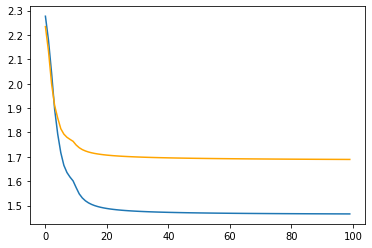

In [ ]:
plt.plot(ltla)
plt.plot(lvla,color="orange")

In [ ]:
plt.plot(lacca)

In [ ]:
test([attack_log],test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


{'avg_test_acc': 80.21, 'avg_test_loss': 1.6781573152542115}

## Membership inference on victim model

In [ ]:
log_model=LogisticRegression(784,10)
log_model.load_state_dict(torch.load("/content/drive/MyDrive/trained_models/log_model.pt"))

<All keys matched successfully>

In [ ]:
batch_size = 100
n_iters = 300
epochs =400 # n_iters / (len(train_loader) / batch_size)
input_dim = 784
output_dim = 10
lr_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(log_model.parameters(), lr=lr_rate)
scheduler=torch.optim.lr_scheduler.ConstantLR(optimizer,0.8)

In [ ]:
log_art_model = PyTorchClassifier(model=log_model, loss=criterion, optimizer=optimizer, input_shape=(784,), nb_classes=10)
pred = np.array([np.argmax(arr) for arr in log_art_model.predict(x_test)])

print('Base model accuracy: ', 100*sum(pred == np.argmax(y_test,axis=1)) / len(y_test))

Base model accuracy:  92.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


In [ ]:
log_attack = MembershipInferenceBlackBoxRuleBased(log_art_model)

# infer 
log_inferred_train = log_attack.infer(x_train.squeeze(), y_train)
log_inferred_test = log_attack.infer(x_test.squeeze(), y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


In [ ]:
log_train_acc = np.sum(log_inferred_train) / len(log_inferred_train)
log_test_acc = 1 - (np.sum(log_inferred_test) / len(log_inferred_test))
log_acc = (log_train_acc * len(log_inferred_train) + log_test_acc * len(log_inferred_test)) / (len(log_inferred_train) + len(log_inferred_test))
print("Accuracy on train set",log_train_acc)
print("Accuracy on test set",log_test_acc)
print("Overall accuracy",log_acc)

print("Precision, Recall:",calc_precision_recall(np.concatenate((log_inferred_train, log_inferred_test)), 
                            np.concatenate((np.ones(len(log_inferred_train)), np.zeros(len(log_inferred_test))))))

Accuracy on train set 0.91874
Accuracy on test set 0.07999999999999996
Overall accuracy 0.77895
Precision, Recall: (0.8331428985980376, 0.91874)


## Membership inference on attacker model

In [ ]:
log_att_model=LogisticRegression(784,10)
log_att_model.load_state_dict(torch.load("/content/drive/MyDrive/trained_models/attack_log.pt"))

<All keys matched successfully>

In [ ]:
batch_size = 100
n_iters = 300
epochs =400 # n_iters / (len(train_loader) / batch_size)
input_dim = 784
output_dim = 10
lr_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(log_att_model.parameters(), lr=lr_rate)
scheduler=torch.optim.lr_scheduler.ConstantLR(optimizer,0.8)

In [ ]:
log_att_art_model = PyTorchClassifier(model=log_att_model, loss=criterion, optimizer=optimizer, input_shape=(784,), nb_classes=10)
pred = np.array([np.argmax(arr) for arr in log_att_art_model.predict(x_test)])

print('Attack model accuracy: ', 100*sum(pred == np.argmax(y_test,axis=1)) / len(y_test))

Attack model accuracy:  80.21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


In [ ]:
log_att_attack = MembershipInferenceBlackBoxRuleBased(log_att_art_model)

# infer 
log_att_inferred_train = log_attack.infer(x_train.squeeze(), y_train)
log_att_inferred_test = log_attack.infer(x_test.squeeze(), y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


In [ ]:
log_att_train_acc = np.sum(log_att_inferred_train) / len(log_att_inferred_train)
log_att_test_acc = 1 - (np.sum(log_att_inferred_test) / len(log_att_inferred_test))
log_att_acc = (log_att_train_acc * len(log_att_inferred_train) + log_att_test_acc * len(log_att_inferred_test)) / (len(log_att_inferred_train) + len(log_att_inferred_test))
print("Accuracy on train set",log_att_train_acc)
print("Accuracy on test set",log_att_test_acc)
print("Overall accuracy",log_att_acc)

print("Precision, Recall:",calc_precision_recall(np.concatenate((log_att_inferred_train, log_att_inferred_test)), 
                            np.concatenate((np.ones(len(log_att_inferred_train)), np.zeros(len(log_att_inferred_test))))))

Accuracy on train set 0.91874
Accuracy on test set 0.07999999999999996
Overall accuracy 0.77895
Precision, Recall: (0.8331428985980376, 0.91874)


## Data reconstruction attack on cnn model

# Attack on base model

In [ ]:
cnn_model=CNN()
cnn_model.load_state_dict(torch.load("/content/drive/MyDrive/trained_models/cnn_model.pt"))

<All keys matched successfully>

In [ ]:
classifier_cnn = PyTorchClassifier(
    model=cnn_model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(28,28),
    nb_classes=10,
)

In [ ]:
classifier_cnn.fit(x_train.reshape(x_train.size(0),1,28,28), y_train, nb_epochs=500, batch_size=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
attack = MIFace(classifier_cnn, max_iter=10000, threshold=1.) 

In [ ]:
y = np.arange(10)

In [ ]:
x_init_black = np.zeros((10, 1, 28, 28),dtype="float32")
x_init_white = np.ones((10,1, 28, 28),dtype="float32")
x_init_grey = np.zeros((10,1, 28, 28),dtype="float32") + 0.5
x_init_random = np.random.uniform(0, 1, (10,1, 28, 28))
x_init_average = np.zeros((10,1, 28, 28),dtype="float32") + np.mean(x_test.reshape(x_test.size(0),1,28,28).long().cpu().detach().numpy(), axis=0)

In [ ]:
class_gradient = classifier_cnn.class_gradient(x_init_black, y)
class_gradient = np.reshape(class_gradient, (10, 784))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))


Minimum over all maximum class gradient: 0.031721


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
# Now we run the attack:
x_infer_from_black = attack.infer(x=x_init_black,y=y)

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


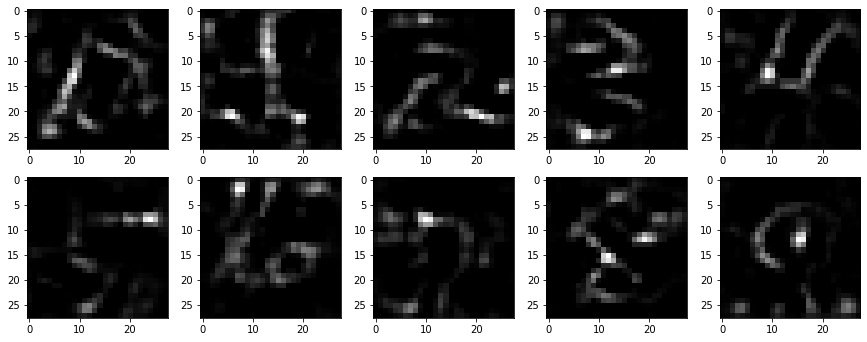

In [ ]:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_black[0+i,], (28, 28))), cmap=plt.cm.gray)

# Attack on attacker model

In [ ]:
classifier_cnn_att = PyTorchClassifier(
    model=cnn_att_model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(28,28),
    nb_classes=10,
)

In [ ]:
attack_att = MIFace(classifier_cnn_att, max_iter=10000, threshold=1.) 

In [ ]:
# Now we run the attack:
x_infer_att = attack_att.infer(x=x_init_grey,y=y)

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


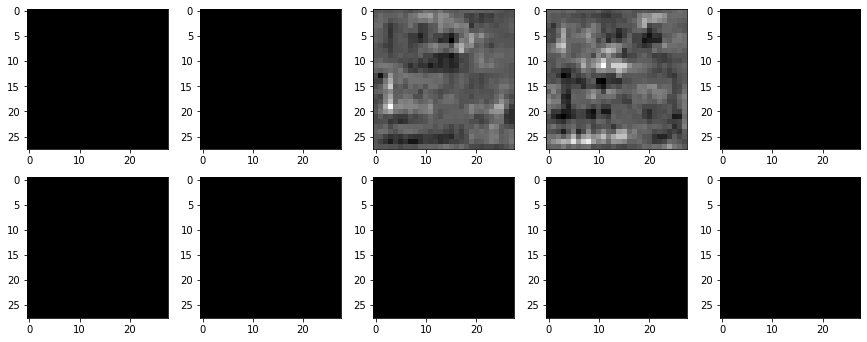

In [ ]:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_att[0+i,], (28, 28))), cmap=plt.cm.gray)

## Attack CNN with logistic reg model

In [ ]:
batch_size = 100
n_iters = 300
epochs =400 # n_iters / (len(train_loader) / batch_size)
input_dim = 784
output_dim = 10
lr_rate = 0.01
criterion = nn.CrossEntropyLoss()
attack_log=LogisticRegression(784,10)
optimizer = torch.optim.SGD(attack_log.parameters(), lr=lr_rate)
scheduler=torch.optim.lr_scheduler.ConstantLR(optimizer,0.8)

In [ ]:
t,v,a=attack_loop(cnn_model,attack_log,gen_loader,valid_loader,200,"cnn_att_log.pt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 		 Training Loss: 2.2585265431404116 		 Validation Loss: 2.214124596118927
Validation accuracy 42.41
Validation Loss Decreased(inf--->2.214125) 	 Saving The Model
Epoch 2 		 Training Loss: 2.146555152416229 		 Validation Loss: 2.090426120758057
Validation accuracy 59.36
Validation Loss Decreased(2.214125--->2.090426) 	 Saving The Model
Epoch 3 		 Training Loss: 1.9953461985588075 		 Validation Loss: 1.9759639978408814
Validation accuracy 61.26
Validation Loss Decreased(2.090426--->1.975964) 	 Saving The Model
Epoch 4 		 Training Loss: 1.8741087379455565 		 Validation Loss: 1.9056897246837616
Validation accuracy 67.1
Validation Loss Decreased(1.975964--->1.905690) 	 Saving The Model
Epoch 5 		 Training Loss: 1.7877549507617951 		 Validation Loss: 1.8623121225833892
Validation accuracy 69.05
Validation Loss Decreased(1.905690--->1.862312) 	 Saving The Model
Epoch 6 		 Training Loss: 1.7359849274158479 		 Validation Loss: 1.8378496193885803
Validation accuracy 69.14
Validation Los

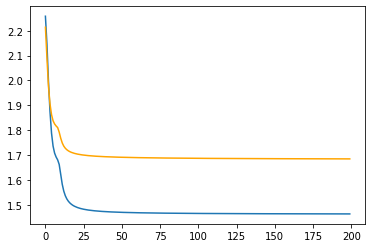

In [ ]:
plt.plot(t)
plt.plot(v,color="orange")

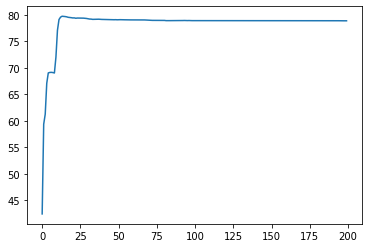

In [ ]:
plt.plot(a)

In [ ]:
test([attack_log],test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


{'avg_test_acc': 80.12, 'avg_test_loss': 1.6735499382019043}

## Attack Logistic Reg with CNN model

In [ ]:
batch_size = 100
n_iters = 300
epochs =400 # n_iters / (len(train_loader) / batch_size)
input_dim = 784
output_dim = 10
lr_rate = 0.01
criterion = nn.CrossEntropyLoss()
attack_cnn=CNN()
optimizer = torch.optim.SGD(attack_cnn.parameters(), lr=lr_rate)
scheduler=torch.optim.lr_scheduler.ConstantLR(optimizer,0.8)

In [ ]:
t2,v2,a2=attack_loop(log_model,attack_cnn,gen_loader,valid_loader,200,"log_att_cnn.pt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Epoch 1 		 Training Loss: 2.3020516748428346 		 Validation Loss: 2.301898856163025
Validation accuracy 15.03
Validation Loss Decreased(inf--->2.301899) 	 Saving The Model
Epoch 2 		 Training Loss: 2.3012613344192503 		 Validation Loss: 2.3010437989234926
Validation accuracy 14.4
Validation Loss Decreased(2.301899--->2.301044) 	 Saving The Model
Epoch 3 		 Training Loss: 2.3002430362701416 		 Validation Loss: 2.2999732995033266
Validation accuracy 12.93
Validation Loss Decreased(2.301044--->2.299973) 	 Saving The Model
Epoch 4 		 Training Loss: 2.2989750080108644 		 Validation Loss: 2.2984906959533693
Validation accuracy 11.71
Validation Loss Decreased(2.299973--->2.298491) 	 Saving The Model
Epoch 5 		 Training Loss: 2.2971755170822146 		 Validation Loss: 2.296222860813141
Validation accuracy 11.38
Validation Loss Decreased(2.298491--->2.296223) 	 Saving The Model
Epoch 6 		 Training Loss: 2.293646499156952 		 Validation Loss: 2.2905140209197996
Validation accuracy 10.56
Validation Los

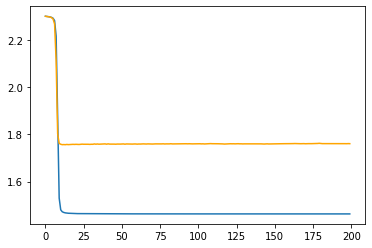

In [ ]:
plt.plot(t2)
plt.plot(v2,color="orange")

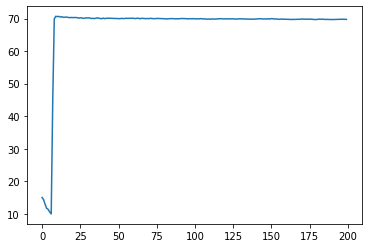

In [ ]:
plt.plot(a2)

In [ ]:
test([attack_cnn],test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


{'avg_test_acc': 70.95, 'avg_test_loss': 1.7497746360301971}